# SF Bikeshare Data Exploration with Google BigQuery SQL
This project serves as a proof of concept project for BigQuery SQL by interacting with the historic San Francisco bikeshare data hosted on Google's [BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data/). More recent or real-time San Francisco bikeshare data (now known as Lyft Bay Wheels) can be found [here](https://www.lyft.com/bikes/bay-wheels/system-data), which is not used in this project. 

In [4]:
%%HTML 
# embed link

### Authentication with Google BigQuery service account key file

Before connecting to the Jupyter server, do the following in terminal window:

1. export GOOGLE_APPLICATION_CREDENTIALS="/your/service/account/file/path/[FILE_NAME].json"
2. pip install --upgrade google-cloud-bigquery

In [6]:
from google.cloud import bigquery
client = bigquery.Client()
%load_ext google.cloud.bigquery

#### Query behind the visualziation above

In [56]:
query = """
        SELECT
            t.start_date AS start_date,
            t.trip_id AS trip_id,
            t.duration_sec AS duration,
            t.start_station_name AS origin_station,
            t.end_station_name AS destination_station,
            t.bike_number AS bike_number,
            t.subscriber_type AS subscriber_type,
            origin.latitude AS origin_lat,
            origin.longitude AS origin_lon,
            desti.latitude AS destination_lat,
            desti.longitude AS destination_lon
        FROM
            `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` t
            LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_stations` origin
            ON t.start_station_id = origin.station_id
            LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_stations` desti
            ON t.end_station_id = desti.station_id
        WHERE
            EXTRACT(MONTH FROM start_date) = 5 
            AND EXTRACT(YEAR FROM start_date) = 2016
        """

## Import necessary packages

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pandas.api.types import CategoricalDtype
import plotly as ply
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#F5F5F5'

%matplotlib inline

### Preliminary Stuff

#### What tables does the San Francisco Bikeshare dataset have?

In [8]:
data_ref = client.dataset("san_francisco_bikeshare", project="bigquery-public-data")
data = client.get_dataset(data_ref)

tables = list(client.list_tables(data))
for table in tables:
    print(table.table_id)

bikeshare_regions
bikeshare_station_info
bikeshare_station_status
bikeshare_trips


#### Check schema for the bikeshare_trips table

In [9]:
client.get_table(data_ref.table("bikeshare_trips")).schema

[SchemaField('trip_id', 'INTEGER', 'REQUIRED', 'Numeric ID of bike trip', ()),
 SchemaField('duration_sec', 'INTEGER', 'NULLABLE', 'Time of trip in seconds', ()),
 SchemaField('start_date', 'TIMESTAMP', 'NULLABLE', 'Start date of trip with date and time, in PST', ()),
 SchemaField('start_station_name', 'STRING', 'NULLABLE', 'Station name of start station', ()),
 SchemaField('start_station_id', 'INTEGER', 'NULLABLE', 'Numeric reference for start station', ()),
 SchemaField('end_date', 'TIMESTAMP', 'NULLABLE', 'End date of trip with date and time, in PST', ()),
 SchemaField('end_station_name', 'STRING', 'NULLABLE', 'Station name for end station', ()),
 SchemaField('end_station_id', 'INTEGER', 'NULLABLE', 'Numeric reference for end station', ()),
 SchemaField('bike_number', 'INTEGER', 'NULLABLE', 'ID of bike used', ()),
 SchemaField('zip_code', 'STRING', 'NULLABLE', 'Home zip code of subscriber (customers can choose to manually enter zip at kiosk however data is unreliable)', ()),
 Schema

#### Sneak peak of the bikeshare_trips table

In [10]:
table_ref = data_ref.table("bikeshare_trips")
table = client.get_table(table_ref)
client.list_rows(table, max_results=5).to_dataframe()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,...,c_subscription_type,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year,member_gender,bike_share_for_all_trip,start_station_geom,end_station_geom
0,14620140831185000,1353,2014-08-31 18:50:00+00:00,California Ave Caltrain Station,36,2014-08-31 19:13:00+00:00,San Antonio Caltrain Station,29,146,94040,...,None,None,None,None,None,None,None,None,None,None
1,24320140831104700,2105,2014-08-31 10:47:00+00:00,St James Park,13,2014-08-31 11:22:00+00:00,St James Park,13,243,95112,...,None,None,None,None,None,None,None,None,None,None
2,17920140830180000,383,2014-08-30 18:00:00+00:00,San Antonio Shopping Center,31,2014-08-30 18:07:00+00:00,Rengstorff Avenue / California Street,33,179,94040-1724,...,None,None,None,None,None,None,None,None,None,None
3,16120140829165400,273,2014-08-29 16:54:00+00:00,San Pedro Square,6,2014-08-29 16:58:00+00:00,Ryland Park,84,161,94550,...,None,None,None,None,None,None,None,None,None,None
4,71420140826183800,241,2014-08-26 18:38:00+00:00,Cowper at University,37,2014-08-26 18:42:00+00:00,Palo Alto Caltrain Station,34,714,94133,...,None,None,None,None,None,None,None,None,None,None


### BigQuery SQL 

#### What's the time frame of the data
Obtain a table showing the earliest/latest data points and the totoal days of coverage.

In [22]:
time_frame_query = """
        WITH time_frame AS
        (
            SELECT
                MIN(start_date) AS earliest_date,
                MAX(start_date) AS latest_date
            FROM
                `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
        )
        SELECT
            earliest_date,
            latest_date,
            TIMESTAMP_DIFF(latest_date, earliest_date, DAY) AS total_num_days
        FROM
            time_frame
        """
time_frame = client.query(time_frame_query).result().to_dataframe()
time_frame

,earliest_date,latest_date,total_num_days
0,2013-08-29 09:08:00+00:00,2018-04-30 23:58:45+00:00,1705


#### How many trips were there and by whom?
Obtain a table showing number of trips broken down by subscriber type.

In [24]:
trips_query = """
        SELECT 
            COUNT(Subscriber_trip) Subscriber_Trips, 
            COUNT(Customer_trip) Customer_Trips, 
            COUNT(*) Total_Trips
        FROM 
            (SELECT 
                CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
                CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
            FROM 
                `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`)
        """

trips = client.query(trips_query).to_dataframe()
trips

,Subscriber_Trips,Customer_Trips,Total_Trips
0,1635448,311971,1947419


#### The same query as above, but using magic commands (just for fun)

In [25]:
%%bigquery
SELECT 
    COUNT(Subscriber_trip) Subscriber_Trips, 
    COUNT(Customer_trip) Customer_Trips, 
    COUNT(*) Total_Trips
FROM 
    (SELECT 
        CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
        CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`)

,Subscriber_Trips,Customer_Trips,Total_Trips
0,1635448,311971,1947419


#### Let's break down trips by month and subscriber type
Obtain a table showing monthly trips by subscriber type
- Data from 4/1/2014 to 4/30/2018 is queried to make sure each month is inlcuded five times

In [84]:
trips_by_month_query = """
                 SELECT
                     FORMAT_DATE('%B', DATE(start_date)) AS month,
                     COUNT(Subscriber_trip) AS subscriber_trips, 
                     COUNT(Customer_trip) AS customer_trips, 
                     COUNT(*) AS total_trips
                 FROM
                     (SELECT
                        start_date,
                        CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
                        CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
                      FROM 
                        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                      WHERE
                        start_date >= '2014-01-01' AND start_date < '2018-05-01')
                 GROUP BY
                     1
                 ORDER BY
                     4 DESC
                 """

trips_by_month = client.query(trips_by_month_query).to_dataframe()
trips_by_month

,month,subscriber_trips,customer_trips,total_trips
0,April,184207,31158,215365
1,March,166694,26465,193159
2,August,139885,36881,176766
3,February,153980,22723,176703
4,October,144887,29323,174210
5,January,146533,20057,166590
6,September,128618,32018,160636
7,November,123626,20858,144484
8,July,107482,26130,133612
9,December,108085,16521,124606


Plot it

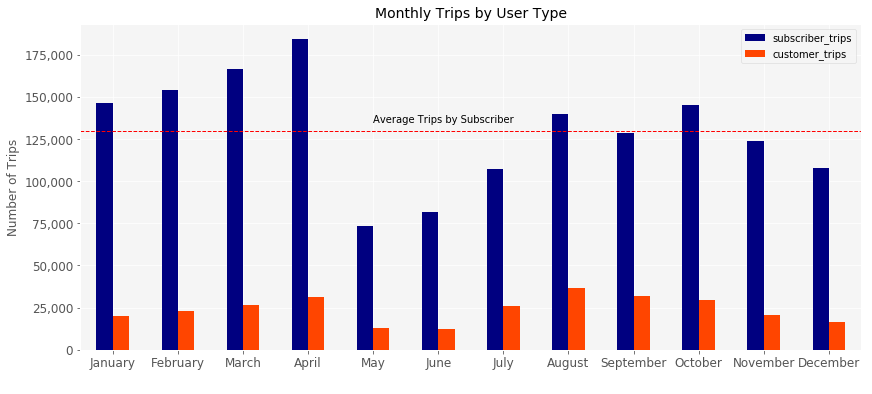

In [123]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

trips_by_month['month'] = pd.Categorical(trips_by_month['month'], categories=months, ordered=True)
trips_by_month.sort_values('month', inplace=True)

ax = trips_by_month.set_index('month')[['subscriber_trips', 'customer_trips']].plot(
    kind='bar', 
    rot=0, 
    figsize=(14,6), 
    color=['navy', 'orangered']
)

ax.set_title('Monthly Trips by User Type', fontsize=14)
ax.set_ylabel('Number of Trips')
ax.set_xlabel(' ')

fmt = '{x:,.0f}'
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)

ax.axhline(trips_by_month['subscriber_trips'].mean(), color='red', linestyle='dashed',linewidth=1)
ax.text(4, 135000,'Average Trips by Subscriber', fontsize=10)

pass

#### Let's break trips further down by day of week and time of day for subscribers
Obtain tables showing trips by day of week and hour of day for subscribers
- Again, data from 4/1/2014 to 4/30/2018 is queried

In [104]:
trips_dow_subscriber = """
                       SELECT 
                           EXTRACT (DAYOFWEEK FROM start_date) AS day_of_week,
                           EXTRACT (HOUR FROM start_date) AS hour,
                           COUNT(*) AS num_trips
                        FROM
                            `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                        WHERE
                            subscriber_type = 'Subscriber'
                            AND start_date >= '2014-01-01' 
                            AND start_date < '2018-05-01'
                        GROUP BY
                            1,2
                        """

trips_dow_customer = """
                       SELECT 
                           EXTRACT (DAYOFWEEK FROM start_date) AS day_of_week,
                           EXTRACT (HOUR FROM start_date) AS hour,
                           COUNT(*) AS num_trips
                        FROM
                            `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                        WHERE
                            subscriber_type = 'Customer'
                            AND start_date >= '2014-01-01' 
                            AND start_date < '2018-05-01'
                        GROUP BY
                            1,2
                        """

trips_dow_sub = client.query(trips_dow_subscriber).to_dataframe()
trips_dow_cus = client.query(trips_dow_customer).to_dataframe()

Plot it

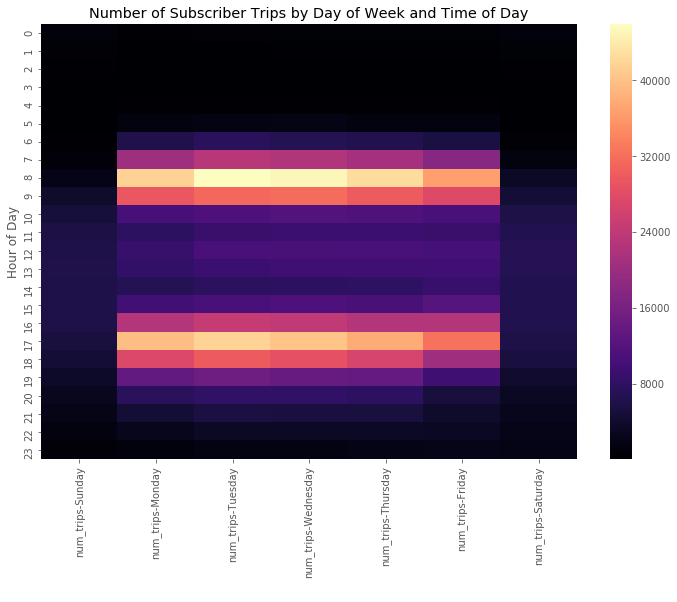

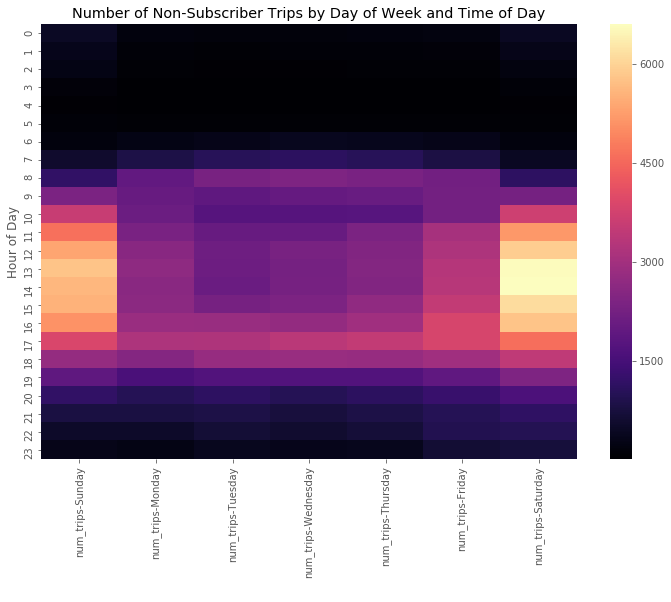

In [109]:
dow_dict = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}

dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
trips_dow_sub['day_of_week'] = trips_dow_sub['day_of_week'].replace(dow_dict)
trips_dow_sub['day_of_week'] = trips_dow_sub['day_of_week'].astype(CategoricalDtype(dow, ordered=True))
trips_dow_cus['day_of_week'] = trips_dow_cus['day_of_week'].replace(dow_dict)
trips_dow_cus['day_of_week'] = trips_dow_cus['day_of_week'].astype(CategoricalDtype(dow, ordered=True))
trips_dow_sub = trips_dow_sub.groupby(['hour', 'day_of_week']).sum().unstack()
trips_dow_cus = trips_dow_cus.groupby(['hour', 'day_of_week']).sum().unstack()


data = [trips_dow_sub, trips_dow_cus]
title = ['Number of {} Trips by Day of Week and Time of Day'.format(i) for i in ('Subscriber', 'Non-Subscriber')]

plot_data = zip(data, title)

for item in plot_data:
    
    fig = plt.figure(figsize=(12,8))
    sns.heatmap(item[0], cmap='magma')

    plt.title(item[1])
    plt.xlabel(' ')
    plt.ylabel('Hour of Day')

pass

# ----- Drafts below -----

AM Peak Trips

In [154]:
%%bigquery
SELECT
    FORMAT("%'d", COUNT(*)) Number_of_Trips,
    ROUND(AVG(duration_sec/60)) Average_Duration_Min,
    COUNT(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`) Trip_Percentage
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
    EXTRACT(HOUR FROM start_date) > 6 AND EXTRACT(HOUR FROM start_date) < 9

,Number_of_Trips,Average_Duration_Min,Trip_Percentage
0,"199,995",11.0,0.20332


PM Peak Trips

In [155]:
%%bigquery
SELECT
    FORMAT("%'d", COUNT(*)) Number_of_Trips,
    ROUND(AVG(duration_sec/60)) Average_Duration_Min,
    COUNT(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`) Trip_Percentage
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
    EXTRACT(HOUR FROM start_date) > 16 AND EXTRACT(HOUR FROM start_date) < 19

,Number_of_Trips,Average_Duration_Min,Trip_Percentage
0,"210,871",13.0,0.214376


Trip by Hour

In [156]:
%%bigquery
SELECT 
    EXTRACT(HOUR FROM start_date) Hour,
    COUNT(*) Number_of_Trips,
    COUNT(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`) Trip_Percentage,
    ROUND(AVG(duration_sec/60)) Average_Duration_Min
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY 1
ORDER BY 1

,Hour,Number_of_Trips,Trip_Percentage,Average_Duration_Min
0,0,2929,0.002978,27.0
1,1,1611,0.001638,49.0
2,2,877,0.000892,73.0
3,3,605,0.000615,136.0
4,4,1398,0.001421,20.0
5,5,5098,0.005183,18.0
6,6,20519,0.020860,14.0
7,7,67531,0.068654,11.0
8,8,132464,0.134666,11.0
9,9,96118,0.097716,13.0


#### Popular Routes

In [162]:
%%bigquery
SELECT 
    t.start_station_name StationName, 
    s.latitude start_lat, 
    s.longitude start_lon, 
    e.latitude end_lat, 
    e.longitude end_lon, 
    count(*) AS NumTrips
FROM 
    `bigquery-public-data.san_francisco.bikeshare_trips` t
JOIN 
    `bigquery-public-data.san_francisco.bikeshare_stations` s
ON 
    t.start_station_id = s.station_id
JOIN 
    `bigquery-public-data.san_francisco.bikeshare_stations` e
ON 
    t.end_station_id = e.station_id
GROUP BY 
    StationName, 
    start_lat, 
    start_lon, 
    end_lat, 
    end_lon
ORDER BY 6 DESC
LIMIT 10

,StationName,start_lat,start_lon,end_lat,end_lon,NumTrips
0,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,37.804770,-122.403234,9150
1,San Francisco Caltrain 2 (330 Townsend),37.776600,-122.395470,37.771058,-122.402717,8508
2,2nd at Townsend,37.780526,-122.390288,37.795392,-122.394203,7620
3,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,37.780526,-122.390288,6888
4,Embarcadero at Sansome,37.804770,-122.403234,37.794139,-122.394434,6874
5,Townsend at 7th,37.771058,-122.402717,37.776600,-122.395470,6836
6,Embarcadero at Folsom,37.791464,-122.391034,37.776617,-122.395260,6351
7,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,37.795392,-122.394203,6215
8,Steuart at Market,37.794139,-122.394434,37.780526,-122.390288,6039
9,Steuart at Market,37.794139,-122.394434,37.776617,-122.395260,5959


#### Cumulative number of trips per day
Since each row of the table corresponds to a different bike trip, and we can use an analytic function to calculate the cumulative number of trips for each date in 2017.

In [11]:
num_trips_query = """
                  WITH trips_by_day AS 
                  (
                      SELECT
                          DATE(start_date) AS trip_date,
                          COUNT(*) AS num_trips
                      FROM
                          `bigquery-public-data.san_francisco.bikeshare_trips`
                      WHERE
                          EXTRACT(YEAR FROM start_date) = 2015
                      GROUP BY
                          trip_date
                  )
                  SELECT
                      trip_date,
                      SUM(num_trips) OVER(
                                          ORDER BY trip_date
                                          ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                                          ) AS cumulative_trips
                  FROM
                      trips_by_day
                  """

num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.tail()

,trip_date,cumulative_trips
360,2015-12-27,344692
361,2015-12-28,345167
362,2015-12-29,345669
363,2015-12-30,345988
364,2015-12-31,346252


#### Track the beginning and ending stations for each bike on March 07, 2016

In [83]:
query = """
        SELECT
            DISTINCT bike_number,
            FIRST_VALUE(start_station_name) 
                OVER(
                    PARTITION BY bike_number
                    ORDER BY start_date
                    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                    ) AS first_station,
            LAST_VALUE(end_station_name)
                OVER(
                    PARTITION BY bike_number
                    ORDER BY start_date
                    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                    ) AS last_station
            FROM
                `bigquery-public-data.san_francisco.bikeshare_trips`
            WHERE
                DATE(start_date) = '2016-03-07'
        """

station_tracking_result = client.query(query).result().to_dataframe()
station_tracking_result.head()

,bike_number,first_station,last_station
0,12,Castro Street and El Camino Real,Mountain View Caltrain Station
1,15,Santa Clara at Almaden,Japantown
2,16,Broadway St at Battery St,Market at Sansome
3,25,Spear at Folsom,Temporary Transbay Terminal (Howard at Beale)
4,29,San Francisco City Hall,Powell Street BART


#### Average daily trips, calculated over a window including preceding 15 days and following 15 days in 2015

In [6]:
query = """
        WITH daily_trips AS
        (
            SELECT
                DATE(start_date) AS trip_date,
                COUNT(*) AS num_trips
            FROM
                `bigquery-public-data.san_francisco.bikeshare_trips`
            WHERE
                start_date >= '2015-05-01' 
                AND start_date < '2016-06-01'
            GROUP BY
                trip_date
        )
        SELECT
            trip_date,
            AVG(num_trips) OVER(
                                ORDER BY trip_date
                                ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING
                                ) AS avg_num_trips
        FROM
            daily_trips
        """

avg_num_trips = client.query(query).result().to_dataframe()
avg_num_trips.head()

,trip_date,avg_num_trips
0,2015-05-01,1006.375000
1,2015-05-02,966.470588
2,2015-05-03,983.833333
3,2015-05-04,1004.736842
4,2015-05-05,1016.800000


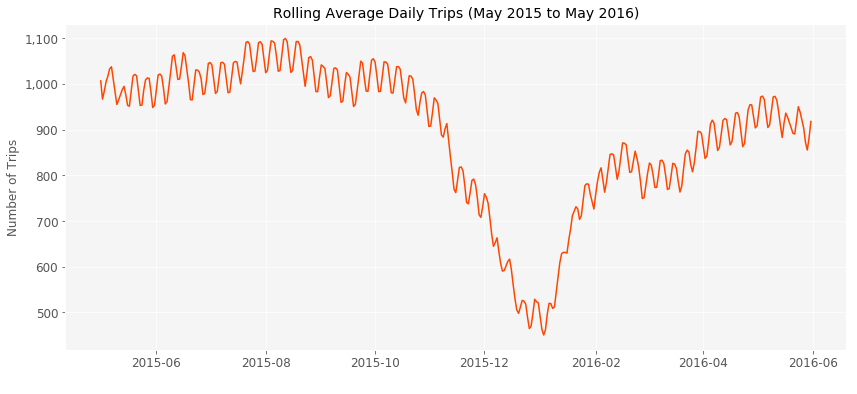

In [7]:
ax = avg_num_trips.set_index('trip_date').plot(
    kind='line', 
    rot=0, 
    figsize=(14, 6), 
    color=['orangered']
)

ax.set_title('Rolling Average Daily Trips (May 2015 to May 2016)', fontsize=14)
ax.set_ylabel('Number of Trips')
ax.set_xlabel(' ')
ax.get_legend().remove()

fmt = '{x:,.0f}'
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)

pass

In [4]:
%%bigquery popular_trips
SELECT 
    t.start_station_name, 
    t.end_station_name, 
    s.latitude start_lat, 
    s.longitude start_lon, 
    e.latitude end_lat, 
    e.longitude end_lon, 
    count(*) NumTrips
FROM `bigquery-public-data.san_francisco.bikeshare_trips` t
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` s
ON t.start_station_id = s.station_id
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` e
ON t.end_station_id = e.station_id
GROUP BY t.start_station_name, t.end_station_name, s.latitude, s.longitude, e.latitude, e.longitude
ORDER BY count(*) DESC

In [10]:
popular_trips

,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,NumTrips
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,37.795392,-122.394203,37.804770,-122.403234,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,37.776600,-122.395470,37.771058,-122.402717,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),37.780526,-122.390288,37.795392,-122.394203,7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,37.795392,-122.394203,37.780526,-122.390288,6888
4,Embarcadero at Sansome,Steuart at Market,37.804770,-122.403234,37.794139,-122.394434,6874
5,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),37.771058,-122.402717,37.776600,-122.395470,6836
6,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),37.791464,-122.391034,37.776617,-122.395260,6351
7,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),37.776617,-122.395260,37.795392,-122.394203,6215
8,Steuart at Market,2nd at Townsend,37.794139,-122.394434,37.780526,-122.390288,6039
9,Steuart at Market,San Francisco Caltrain (Townsend at 4th),37.794139,-122.394434,37.776617,-122.395260,5959


### Most popular Stations

In [166]:
%%bigquery
SELECT 
    station.name AS Station,
    count(*) Number_of_Trips
FROM
    `bigquery-public-data.san_francisco.bikeshare_stations` station
INNER JOIN
    `bigquery-public-data.san_francisco.bikeshare_trips` trip
ON
    station.station_id = trip.start_station_id
GROUP BY
    Station
ORDER BY
    2 DESC
LIMIT 10

,Station,Number_of_Trips
0,San Francisco Caltrain (Townsend at 4th),72683
1,San Francisco Caltrain 2 (330 Townsend),56100
2,Harry Bridges Plaza (Ferry Building),49062
3,Embarcadero at Sansome,41137
4,2nd at Townsend,39936
5,Temporary Transbay Terminal (Howard at Beale),39200
6,Steuart at Market,38531
7,Market at Sansome,35142
8,Townsend at 7th,34894
9,Market at 10th,30209
